Simulation Test

Question：If you are planning to enter a position of 100 contracts and hold it for 3 months, using Huobi trading platform with below contract specifications:

-	USDT-Margined swaps
-	Long position
-	the underlying asset is BTC
-	entry prices equals to spot price
-	20% initial margin
-	0.5% maintenance margin

Please build a simulation model and calculate you daily-99% VaR and ES (Expected Shortfall).

Hints: 
1.	You may use API to access historical prices of BTC on Huobi.com (reference link: https://huobiapi.github.io/docs/usdt_swap/v1/en/#api-list ) as inputs if you are using historical method.
2.	You may use Monte Carlo Simulation to simulate the market price for BTC as well. 


## Content Page

#### [Part 1: Extracting USDT-BTC Swaps data using Huobi API](#API)
#### [Part 2: Analysing BTC Price using CoinMarketCap Data](#BTC)
#### [Part 3: Historical Method](#HIST)
#### [Part 4: Monte Carlo Simulation](#MCS)
#### [Conclusion](#CON)
#### [End](#END)
#### [Extra: (ARIMA)](#ARIMA)

<a id="API"></a>
### Part 1: Extracting USDT-BTC Swaps data using Huobi API

In [1]:
# pip install huobi

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
import requests
import json
response_API = requests.get('https://api.hbdm.com/linear-swap-api/v1/swap_contract_info')
url = 'https://api.hbdm.com/linear-swap-api/v1/swap_contract_info'

In [4]:
print(response_API.status_code)

200


In [5]:
data = response_API.text

In [6]:
parse_json = json.loads(data)

In [7]:
prices = pd.DataFrame(parse_json['data'])

In [8]:
prices.drop(columns = ['delivery_date', 'delivery_time'], inplace = True)

<a id='BTC'></a>
### Part 2: Analysing BTC Price 

In [9]:
BTC = pd.read_csv('BTC_Daily_Price.csv')

In [10]:
BTC['Date'] = pd.to_datetime(BTC['Date'], utc = False)

In [11]:
BTC.set_index('Date', inplace = True)

In [12]:
BTC.sort_index(ascending = True, inplace = True)

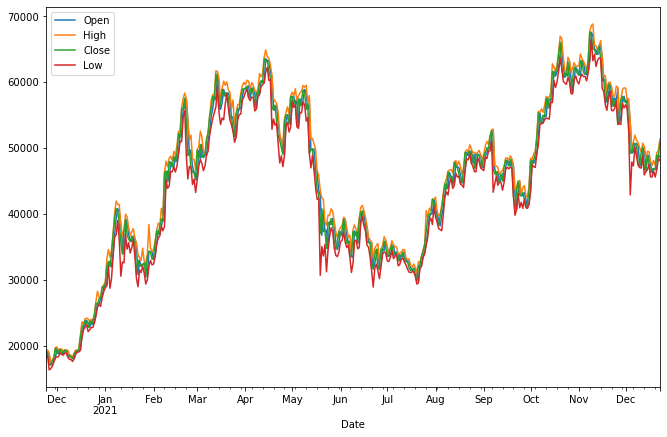

In [13]:
BTC[['Open', 'High', 'Close', 'Low']].plot(figsize = (11, 7))
plt.show()

<a id='HIST'></a>
### Part 3: Historical Method

In [14]:
window = 7 # Use moving average of last 7 days

In [15]:
BTC['Returns'] = np.log(BTC['Close'] / BTC['Close'].shift(-1))

<AxesSubplot:xlabel='Date'>

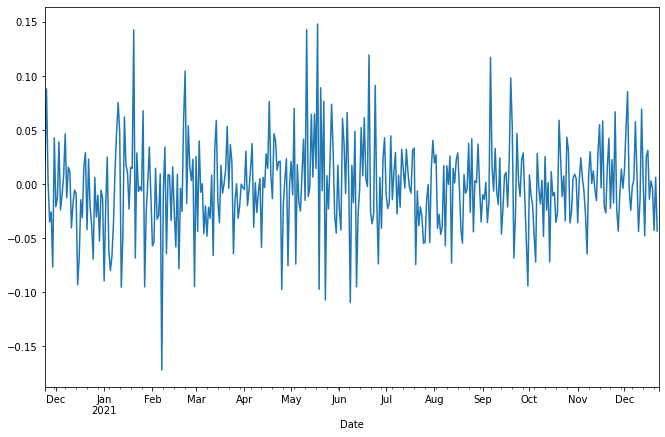

In [16]:
BTC['Returns'].plot(figsize = (11, 7))

In [17]:
BTC['DailyVol'] = BTC['Returns'].rolling(window = window).std()

In [18]:
BTC.dropna(inplace = True)

<AxesSubplot:xlabel='Date'>

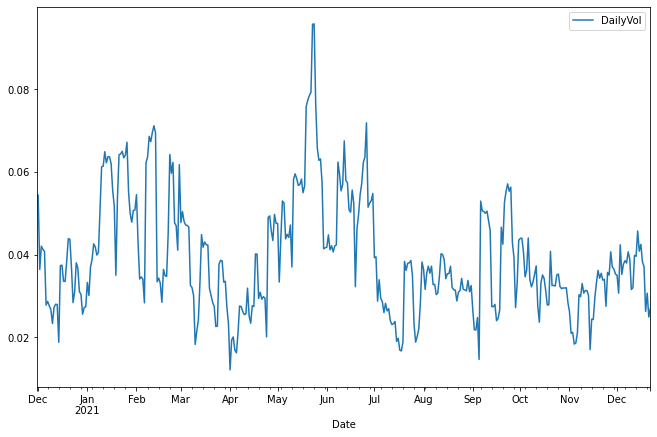

In [19]:
BTC[['DailyVol']].plot(figsize = (11, 7))

In [20]:
three_months = BTC.iloc[296:388]

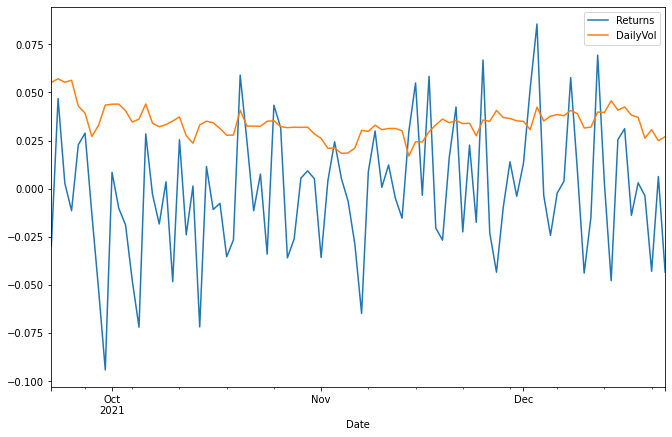

In [64]:
three_months[['Returns', 'DailyVol']].plot(figsize = (11, 7))
plt.show()

In [22]:
def value_at_risk(returns, stdev, zscore):
    var = (returns - (stdev * zscore))
    return var

In [23]:
result = value_at_risk(three_months.Returns, three_months.DailyVol, 2.32)

<AxesSubplot:>

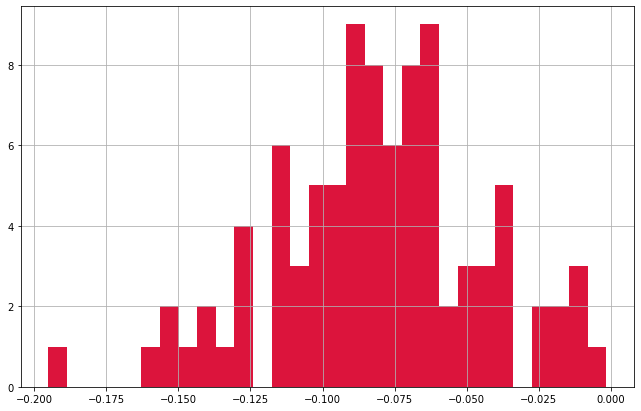

In [24]:
result.hist(bins = 30, figsize = (11, 7), color = 'crimson')

In [25]:
A = result.sort_values(ascending = False)

In [26]:
expected_short_fall = (A.iloc[87:92].mean() * 100)

In [27]:
print('The expected short fall using the historical method is ' '%.2f' % expected_short_fall + '%')

The expected short fall using the historical method is -16.23%


In [28]:
worst_vol = result.min()

In [29]:
worst_vol

-0.1950045343389189

Based on the BTC daily closing price for the last 3 months, we should expect to lose up to **19.5%** with a 99% confidence interval, and have an expected shortfall of up to **16.23%**. 

<a id="MCS"></a>
### Part 4: Monte Carlo Simulation

In [30]:
import datetime as dt
from pandas_datareader import data as pdr
from numpy import random

In [31]:
BTC

,Open,High,Low,Close,Volume,Market Cap,Returns,DailyVol
Date,,,,,,,,
2020-11-30,18178,19749,18178,19626,4.772848e+10,3.642300e+11,0.042839,0.054369
2020-12-01,19634,19846,18322,18803,4.963366e+10,3.489770e+11,-0.020946,0.054362
2020-12-02,18802,19308,18348,19201,3.738770e+10,3.563810e+11,-0.012628,0.036404
2020-12-03,19206,19566,18926,19445,3.193032e+10,3.609340e+11,0.039066,0.042015
2020-12-04,19447,19511,18697,18700,3.387239e+10,3.471110e+11,-0.023988,0.041243
...,...,...,...,...,...,...,...,...
2021-12-18,46219,47314,45598,46849,2.609829e+10,8.856500e+11,0.003036,0.037063
2021-12-19,46854,48090,46503,46707,2.515405e+10,8.830110e+11,-0.003697,0.026247
2021-12-20,46707,47402,45580,46880,3.096190e+10,8.863310e+11,-0.042943,0.030642


In [32]:
def monte_carlo_simulation(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps + 1)
    X = np.c_[np.zeros((paths, 1)), 
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * (X), axis = 1)

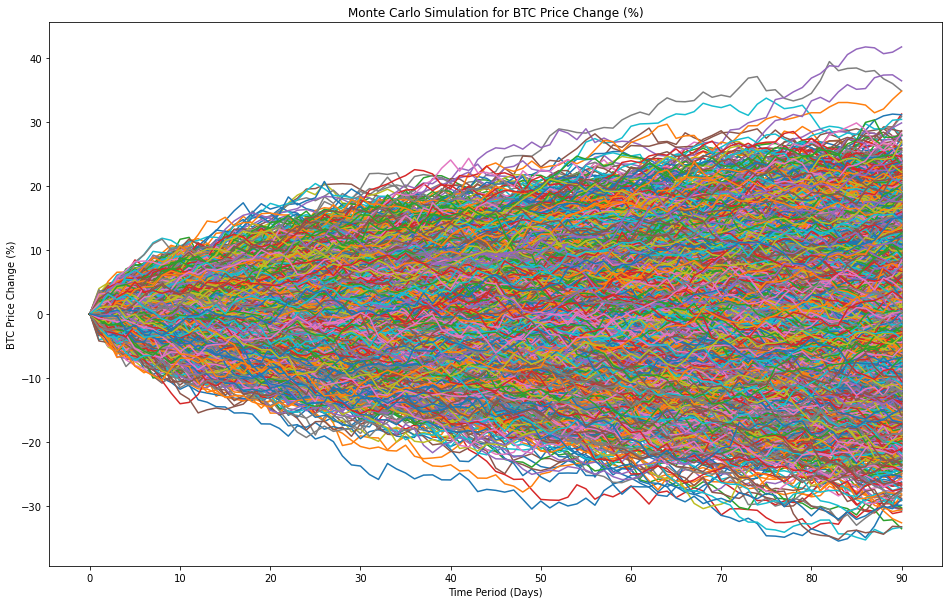

The largest expected gain is 41.7116%
The largest expected loss is -35.5205%


In [33]:
plt.figure(figsize = (16, 10))
t, x = monte_carlo_simulation(10001, 90, 90)
plt.xlabel('Time Period (Days)')
plt.xticks(np.linspace(0, 100, 11))
plt.ylabel('BTC Price Change (%)')
plt.title('Monte Carlo Simulation for BTC Price Change (%)')
plt.plot(t, x.T) 
plt.show()

print('The largest expected gain is ''%.4f' % x.max() + '%')
print('The largest expected loss is ''%.4f' % x.min() + '%')

In [34]:
maximum_gain_percentage = x.max()
maximum_loss_percentage = x.min()

gain = ((1 + (maximum_gain_percentage / 100)) * BTC.Close[-1]) - BTC.Close[-1]
loss = ((1 + (maximum_loss_percentage / 100)) * BTC.Close[-1]) - BTC.Close[-1]

print('Using the Monte Carlo Simulation Method:')
print('The largest expected gain on 1 BTC is ''%.2f' % gain + ' USDT')
print('The largest expected loss on 1 BTC is ''%.2f' % loss + ' USDT')

Using the Monte Carlo Simulation Method:
The largest expected gain on 1 BTC is 20283.94 USDT
The largest expected loss on 1 BTC is -17273.26 USDT


### BTC-USDT Swaps

In [35]:
prices.loc[0:0]

,symbol,contract_code,contract_size,price_tick,create_date,contract_status,settlement_date,support_margin_mode,business_type,pair,contract_type,trade_partition
0,BTC,BTC-USDT,0.001,0.1,20201021,1,1644480000000,all,swap,BTC-USDT,swap,USDT


In [36]:
number_of_contracts = 100
BTC_USDT_swap_price = prices['contract_size'].loc[0:0]

period_T = 90 # days

initial_margin = 0.2
maintenance_margin = 0.005

In [37]:
total_cost = BTC_USDT_swap_price * number_of_contracts # in BTC
print('The total cost of 100 contracts is ' '%.2f' % total_cost + ' BTC')

upfront_capital = total_cost * initial_margin
print('The upfront capital required is ' '%.2f' % upfront_capital + ' BTC')

leverage_factor = total_cost / upfront_capital
print('The leverage factor is ' '%.2f' % leverage_factor + 'X')

minimum_capital = maintenance_margin * upfront_capital
print('The maintenance margin will be triggered when the account balance hits ' '%.6f' % minimum_capital + ' BTC')

The total cost of 100 contracts is 0.10 BTC
The upfront capital required is 0.02 BTC
The leverage factor is 5.00X
The maintenance margin will be triggered when the account balance hits 0.000100 BTC


<a id="CON"></a>
### Conclusion

In [38]:
USDT_capital = upfront_capital * BTC.Close[-1]
USDT_loss = (maximum_loss_percentage / 100) * USDT_capital
historical_loss = worst_vol * USDT_capital

print('We will require an upfront capital of ' '%.2f' % USDT_capital + ' USDT' + ' to enter into the Swap.')
print('Based on the Monte Carlo Simulation, we should expect to lose ' '%.2f' % USDT_loss + ' USDT' + ' within the next 90 days.')
print('Based on the Historical Method, we should expect to lose ' '%.2f' % historical_loss + ' USDT' + ' within the next 90 days.')

We will require an upfront capital of 972.58 USDT to enter into the Swap.
Based on the Monte Carlo Simulation, we should expect to lose -345.47 USDT within the next 90 days.
Based on the Historical Method, we should expect to lose -189.66 USDT within the next 90 days.


<a id="END"></a>
# - END -

<a id="ARIMA"></a>
### Extra: ARIMA
#### Assumptions for ARIMA: 
</a>

Start Date = 13 November 2021
</a>

Training Data has **349** Data Points, or 349 days of daily price data
</a>

Test Data has **39** Data Points, or 39 days of daily price data

In [39]:
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import lag_plot

In [40]:
test = BTC.copy()

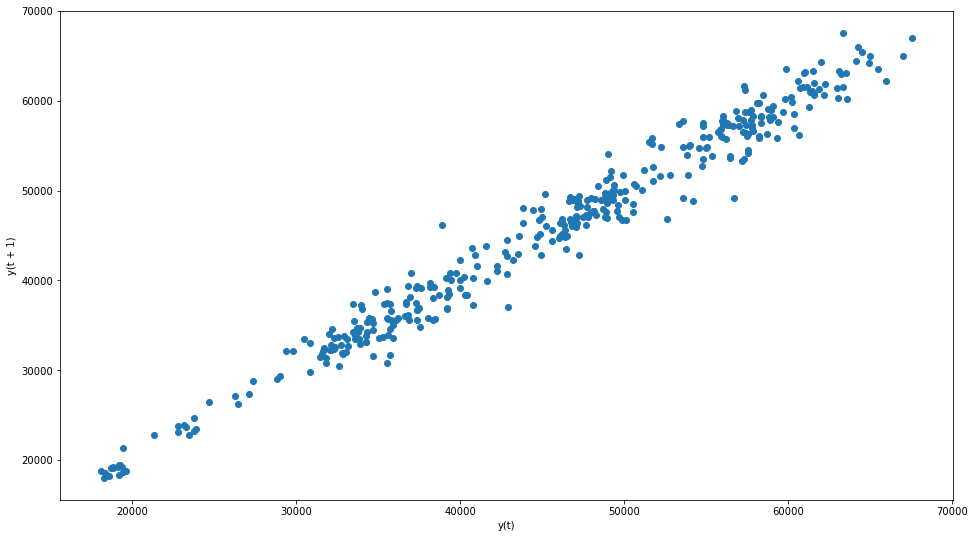

In [41]:
plt.figure(figsize = (16, 9))
lag_plot(test['Close'], lag = 1)
plt.show()

### Stationarity Test - ADF (Augmented Dickey-Fuller) Test

In [42]:
from statsmodels.tsa.stattools import adfuller

In [43]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    
    plt.figure(figsize = (16, 9))
    plt.plot(timeseries, color = "blue", label = "Original")
    plt.plot(rolmean, color = "red", label = "Rolling Mean")
    plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend()
    plt.show()
    
    print("Results of ADF Test")
    adft = adfuller(timeseries, autolag = "AIC")
    output = pd.Series(adft[0:2], index = ["Test Statistic", "p-value"])
    for key, value in adft[4].items():
        output["Critical Value (%s)" % key] = value
    print(output)

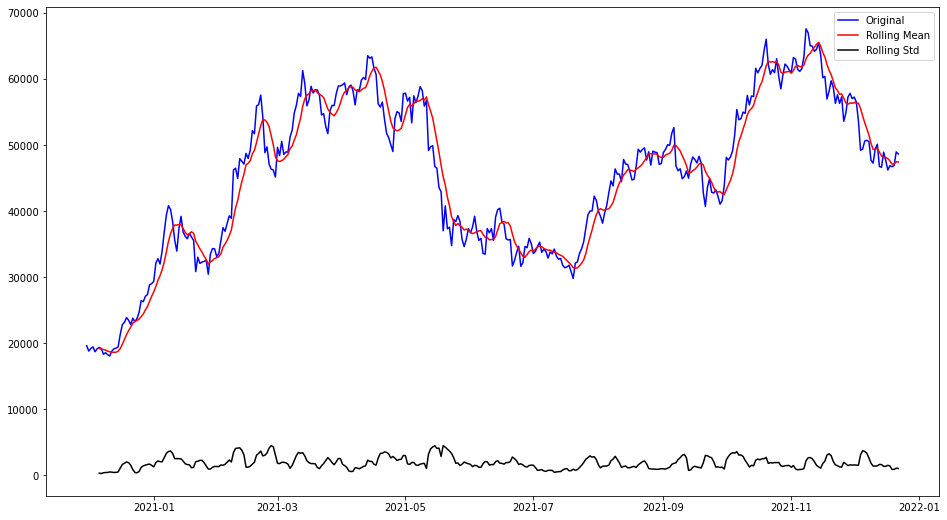

Results of ADF Test
Test Statistic         -2.300873
p-value                 0.171687
Critical Value (1%)    -3.447361
Critical Value (5%)    -2.869037
Critical Value (10%)   -2.570764
dtype: float64


In [44]:
test_stationarity(test['Close'])

Data is ***not*** stationary

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

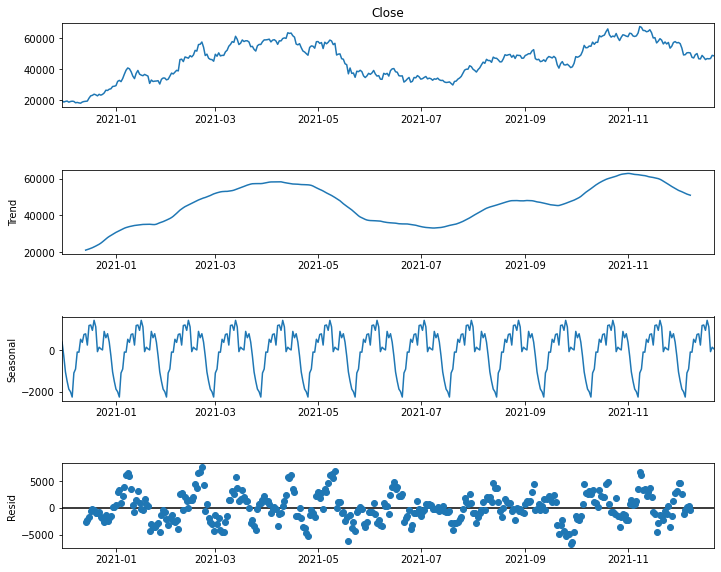

In [46]:
result = seasonal_decompose(test['Close'], period = 28)
result.plot().set_size_inches(11, 9)

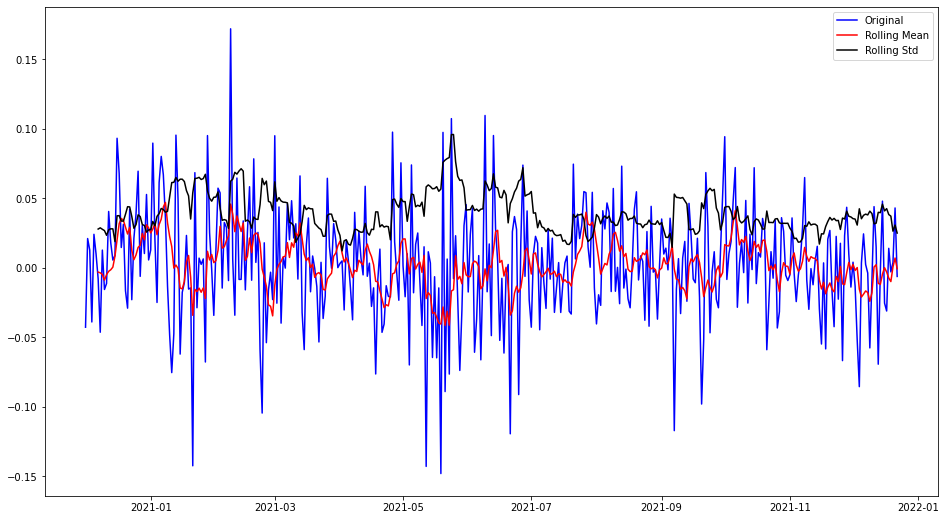

Results of ADF Test
Test Statistic         -20.493601
p-value                  0.000000
Critical Value (1%)     -3.447405
Critical Value (5%)     -2.869057
Critical Value (10%)    -2.570774
dtype: float64


In [47]:
test_log = np.log(test['Close'])

test_log_diff = test_log - test_log.shift(1)

test_log_diff.dropna(inplace = True)

test_stationarity(test_log_diff)

Data is now Stationary

### Data Split

In [48]:
test_size = 0.1
train_size = int(len(test_log) * (1 - test_size))

train_data, test_data = test_log[0:train_size], test_log[train_size:len(test_log)]

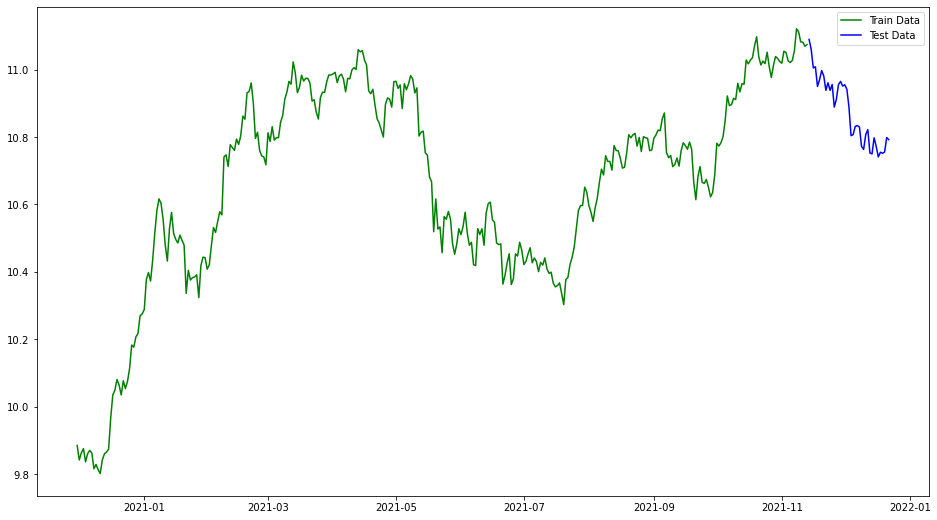

In [49]:
plt.figure(figsize = (16, 9))
plt.plot(train_data, "green", label = "Train Data")
plt.plot(test_data, "blue", label = "Test Data")
plt.legend()
plt.show()

#### Auto-ARIMA

In [50]:
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2644.443, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1197.823, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1196.174, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1191.173, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1202.306, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-240.982, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1201.238, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1200.259, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=162.890, Time=0

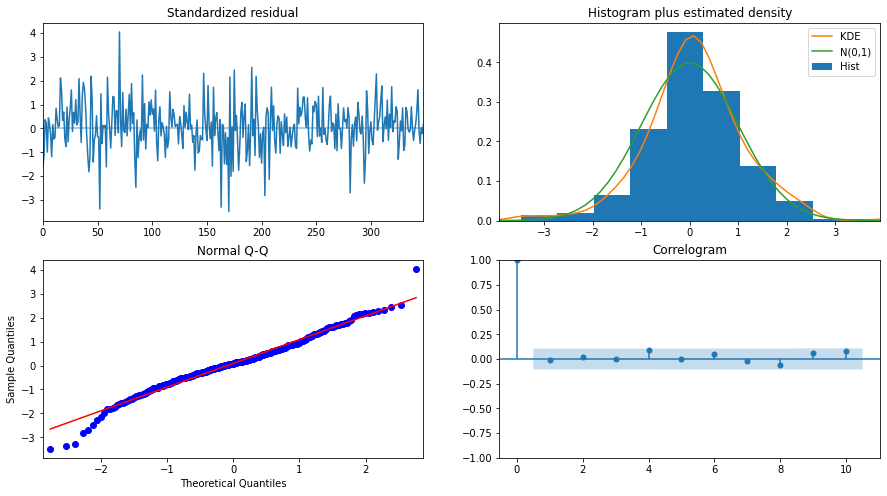

In [51]:
model_autoARIMA = auto_arima(train_data, start_p = 0, start_q = 0,
                             test = "adf",
                             max_p = 5, max_q = 5,
                             m = 3,
                             d = 0,
                             seasonal = False,
                             start_P = 0,
                             D = 0,
                             trace = True,
                             error_action = "ignore",
                             suppress_warnings = True,
                             stepwise = True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize = (15, 8))
plt.show()

### Manual ARIMA

In [52]:
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.arima_model import ARIMA
import pyflux as pf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [53]:
model = ARIMA(train_data, order = (1, 0, 1))
fitted = model.fit(disp = -1)

In [54]:
int(len(test_log) * test_size)

38

In [55]:
fc, se, conf = fitted.forecast(39)

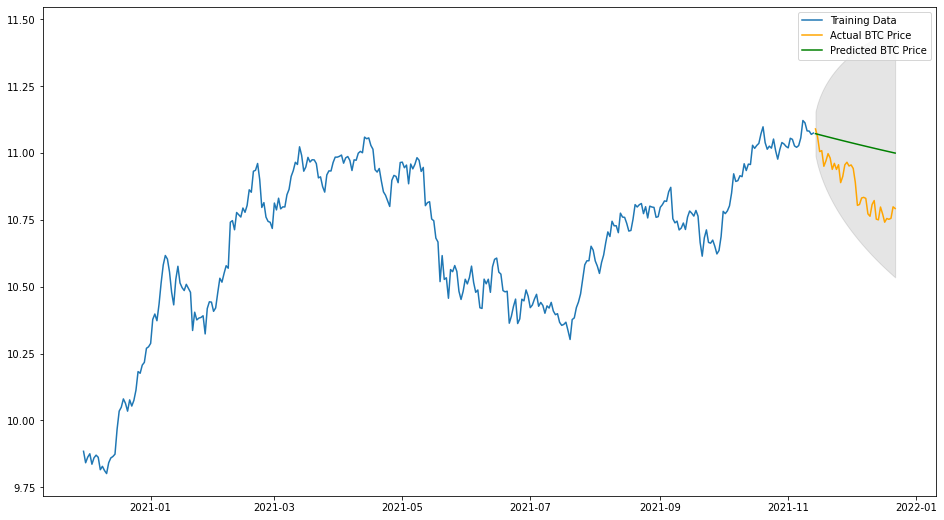

In [56]:
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index = test_data.index)

plt.figure(figsize = (16, 9))
plt.plot(train_data, label = "Training Data")
plt.plot(test_data, color = "orange", label = "Actual BTC Price")
plt.plot(fc_series, color = "green", label = "Predicted BTC Price")
plt.fill_between(lower_series.index, lower_series, upper_series, color = "k", alpha = 0.10)
plt.legend()
plt.show()

In [57]:
train_data[-1]

11.073955278304666

In [58]:
lower_series.min()

10.534579619677086

In [59]:
upper_series.max()

11.46360238668381

In [60]:
max_gain = ((upper_series.max() / train_data[-1]) - 1) * 100
max_loss = ((lower_series.min() / train_data[-1]) - 1) * 100

#### ARIMA Results: 

In [61]:
print('Based on the results from our ARIMA model, after detrending the data, we should expect the maximum gain over a 30 day period to be ' '%.4f' % max_gain + '%')
print('and the maximum loss to be ' '%.4f' % max_loss + '%')

Based on the results from our ARIMA model, after detrending the data, we should expect the maximum gain over a 30 day period to be 3.5186%
and the maximum loss to be -4.8707%
